In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from HMM_Simulator import *

In [81]:
class HMM(object):
    # Construct an HMM from an HMM_simulator object and the state and observation data generated by the simulator
    def __init__(self, simulator, states, obs):
        self.simulator = simulator
        self.numStates = simulator.state_size # number of possibilities for X_i
        self.numOutputs = simulator.obs_size # number of possibilities for Z_i

        # list of sequences generated from the simulator
        self.trainStates = states
        self.trainOutputs = obs
        
        # Set up priors for initial state, transition, and observation matrices
        if simulator.obstacles is not None:
            self.pi = np.full(self.numStates, 1/(self.numStates - len(simulator.obstacles))) # uniform prior over initial states
            self.pi[[simulator.obstacles]] = 0
        else:
            self.pi = np.full(self.numStates, 1/self.numStates)
        self.trans = self.transition_prior(p_stay = 0.2)
        
        #self.trans = self.trans.T
        self.mu = self.simulator.S_type
        self.sigma = self.simulator.sigma

    def transition_prior(self, p_stay = 0.2):
        # Set up prior for transition matrix
        # Modified deterministic version of code in HMM_Simulator that sets up the transition matrix
        ## Second iterate through all the states and fill the transition matrix
        ### Determine corner case
        trans = np.zeros((self.numStates, self.numStates))
        for s in self.simulator.corner_states:
            prow = np.zeros(self.simulator.state_size)
            prow[s] = self.simulator.p_stay + (1.0 - self.simulator.p_stay) / 2
            if s == 0:
                prow[1] = (1.0 - self.simulator.p_stay) / 4.0
                prow[self.simulator.map_size] = (1.0 - self.simulator.p_stay) / 4.0
            elif s == (self.simulator.map_size - 1):
                prow[self.simulator.map_size - 2] = (1.0 - self.simulator.p_stay) / 4.0
                prow[s + self.simulator.map_size] = (1.0 - self.simulator.p_stay) / 4.0
            elif s == (self.simulator.state_size - self.simulator.map_size - 1):
                prow[self.simulator.state_size - 2 * self.simulator.map_size] = (1.0 - self.simulator.p_stay) / 4.0
                prow[self.simulator.state_size - 2 * self.simulator.map_size + 1] = (1.0 - self.simulator.p_stay) / 4.0
            else:
                prow[self.simulator.state_size - 2] = (1.0 - self.simulator.p_stay) / 4.0
                prow[self.simulator.state_size - self.simulator.map_size - 1] = (1.0 - self.simulator.p_stay) / 4.0

            trans[s, :] = prow

        ### Determine the rest
        for s in range(self.simulator.state_size):
            if s in self.simulator.corner_states:
                continue
            prow = np.zeros(self.simulator.state_size)
            if s in self.simulator.north_edge_states:
                prow[s] = self.simulator.p_stay + (1.0 - self.simulator.p_stay) / 4
                prow[s - 1] = (1.0 - self.simulator.p_stay) / 4
                prow[s + 1] = (1.0 - self.simulator.p_stay) / 4
                prow[s + self.simulator.map_size] = (1.0 - self.simulator.p_stay) / 4
            elif s in self.simulator.east_edge_states:
                prow[s] = self.simulator.p_stay + (1.0 - self.simulator.p_stay) / 4
                prow[s - self.simulator.map_size] = (1.0 - self.simulator.p_stay) / 4
                prow[s - 1] = (1.0 - self.simulator.p_stay) / 4
                prow[s + self.simulator.map_size] = (1.0 - self.simulator.p_stay) / 4
            elif s in self.simulator.west_edge_states:
                prow[s] = self.simulator.p_stay + (1.0 - self.simulator.p_stay) / 4
                prow[s - self.simulator.map_size] = (1.0 - self.simulator.p_stay) / 4
                prow[s + 1] = (1.0 - self.simulator.p_stay) / 4
                prow[s + self.simulator.map_size] = (1.0 - self.simulator.p_stay) / 4
            elif s in self.simulator.south_edge_states:
                prow[s] = self.simulator.p_stay + (1.0 - self.simulator.p_stay) / 4
                prow[s - self.simulator.map_size] = (1.0 - self.simulator.p_stay) / 4
                prow[s + 1] = (1.0 - self.simulator.p_stay) / 4
                prow[s - 1] = (1.0 - self.simulator.p_stay) / 4
            else:
                prow[s] = self.simulator.p_stay
                prow[s - self.simulator.map_size] = (1.0 - self.simulator.p_stay) / 4
                prow[s + 1] = (1.0 - self.simulator.p_stay) / 4
                prow[s - 1] = (1.0 - self.simulator.p_stay) / 4
                prow[s + self.simulator.map_size] = (1.0 - self.simulator.p_stay) / 4

            trans[s, :] = prow
            
        if self.simulator.obstacles is not None:
            for s in self.simulator.obstacles:
                trans[s, :] = np.zeros(self.simulator.state_size)
                trans[:, s] = np.zeros(self.simulator.state_size)
        
        row_sums = trans.sum(axis=1)
        trans = trans / row_sums[:, np.newaxis]
        
        return(trans)
    
    # Modified deterministic version of code in HMM_Simulator that sets up observation matrix
#     def observation_prior(self,p_truesignal = 0.7):
#         M = np.zeros((self.numStates, self.numOutputs))
#         for i in range(self.numStates):
#             m_row = np.array([0.7 if k == self.simulator.S_type[i] else 
#                               0.3/(self.numOutputs-1) for k in range(self.numOutputs)])
#             M[i,:] = m_row
#         return(M)
        
    
    # Estimate the transition and observation likelihoods and the
    # prior over the initial state based upon training data
    # Implement the Baum-Welch algorithm
    def train(self, eps = 0.05):

        pi = self.pi
        trans = self.trans
        mu = self.mu
        sigma = self.sigma
        run = 0
        self.loglik = [] # list to track log likelihood
        self.loglik.append(-float('inf'))
        eps = eps # tolerance for convergence

        # Running the Baum-Welch algorithm iteratively over the training set
        # until log-likelihood converges

        while True:
            alphaAll = []
            gammaAll = []
            expect_fromAll = []
            expect_from_toAll = []
            obsResp = []
            for s in range(0,len(self.trainOutputs)):
#                 obsMat = np.zeros((len(self.trainOutputs[s]),self.numOutputs))
#                 obsMat[np.arange(len(self.trainOutputs[s])),self.trainOutputs[s]] = 1
#                 obsMatAll.append(obsMat)

                alpha = np.zeros((len(self.trainOutputs[s]),self.numStates))
                #alpha[0,:] = emit[:,self.trainOutputs[s][0]]*pi
                # npdf = norm.pdf(self.trainOutputs[s],mu,sigma)
                alpha[0,:] = pi*norm.pdf(self.trainOutputs[s][0],mu,sigma)
                for i in range(1,np.shape(alpha)[0]):
                    alpha[i,:] = norm.pdf(self.trainOutputs[s][i],mu,sigma)*np.matmul(trans,alpha[i-1,:])
                alphaAll.append(alpha)

                beta = np.zeros((len(self.trainOutputs[s]),self.numStates))
                beta[-1,:] = 1
                for j in range(2,np.shape(beta)[0]+1):
                    beta[-j,:] = np.matmul(norm.pdf(self.trainOutputs[s][-(j-1)],mu,sigma)*trans.T,beta[-(j-1),:])

                gamma = (alpha*beta)/np.sum(alpha*beta, axis = 1, keepdims = True)
                gammaAll.append(gamma)
                obsResp.append(np.sum(gamma*self.trainOutputs[s][:,np.newaxis],axis = 0))

                # expected number of transitions from state i
                expect_fromi = np.sum(gamma[:-1,:], axis = 0)
                expect_fromAll.append(expect_fromi)

                xi = np.zeros((len(self.trainOutputs[s])-1,self.numStates,self.numStates))
                for t in range(0,(np.shape(xi)[0])):
                    xi[t] = (alpha[t][np.newaxis,:]*trans*(norm.pdf(self.trainOutputs[s][t+1],mu,sigma)[:,np.newaxis])*beta[t+1][:,np.newaxis]).T
                    xi[t] = xi[t]/np.sum(xi[t])
                expect_fromitoj = np.sum(xi, axis = 0)
                expect_from_toAll.append(expect_fromitoj)

            #updating HMM model

            pi = np.mean([g[0] for g in gammaAll], axis = 0)
            trans = np.nan_to_num((np.sum(expect_from_toAll,axis=0)/(np.sum(expect_fromAll,axis=0)[:,np.newaxis])).T)
            #emit = np.nan_to_num(np.sum([np.matmul(gammaAll[i].T,obsMatAll[i]) for i in range(0,len(self.trainOutputs))], axis = 0) / \
                #np.sum([np.sum(g,axis = 0) for g in gammaAll],axis = 0)[:,np.newaxis])
            mu = np.nan_to_num(np.sum(obsResp, axis = 0)/np.sum([np.sum(g,axis = 0) for g in gammaAll],axis = 0))

            # get log likelihood for this iteration
            lik = [np.sum(a[-1]) for a in alphaAll]
            self.loglik.append(np.sum(np.log(lik)))
            run += 1

            #check for convergence
            if (self.loglik[run] - self.loglik[run-1]) < eps: break
            
            # safety check to break while loop in case of bugs
            if run > 1000: break
        
        print(run)
        self.pi = pi
        self.trans = trans
        self.mu = mu

In [76]:
class Viterbi(object):
    # Construct an instance of the viterbi class
    # based upon an instantiation of the HMM class
    def __init__(self, hmm):
        self.hmm = hmm

    # Returns the most likely state sequence for a given output
    # (observation) sequence, i.e.,
    #    arg max_{X_1, X_2, ..., X_T} P(X_1,...,X_T | Z_1,...Z_T)
    # according to the HMM model that was passed to the constructor.
    def mostLikelySequence(self, allObsSeq):
        
        hmm = self.hmm
        xstar = []
        for idx in range(allObsSeq.shape[0]):
            output = allObsSeq[idx,:]
            delta = np.zeros((len(output),hmm.numStates))
            pre = np.zeros((len(output),hmm.numStates))

            delta[0,:] = norm.pdf(output[0],hmm.mu, hmm.sigma)*hmm.pi

            for t in range(1,len(output)):
                px = hmm.trans*delta[t-1,:]
                delta[t,:] = norm.pdf(output[t],hmm.mu, hmm.sigma)*np.amax(px,axis = 1)
                pre[t,:] = np.argmax(px, axis = 1)

            # Select most likely states by backtracking

            xstar.append(np.zeros(len(output),dtype = int))
            xstar[idx][-1] = np.argmax(delta[-1,:])
            for t in range(2,len(output)+1):
                xstar[idx][-t] = pre[-(t-1),xstar[idx][-(t-1)]]
        
        return xstar
        
def measureAccuracy(xstar, stateSeq):
    count = []
    for idx in range(stateSeq.shape[0]):
        states = stateSeq[idx,:]
        count.append(sum(xstar[idx] != states)/len(states))
    return np.mean(count)

Steps:
1. Construct HMM_simulator object
2. Generate data from HMM simulator
3. Construct HMM instance
4. Run HMM and Viterbi to get most likely state sequence estimates
5. Repeat for rest of HMM simulator settings

In [77]:
simul1 = HMM_Simulator(seed = 123, sigma = 0.5, map_size = 5, obs_size = 8)

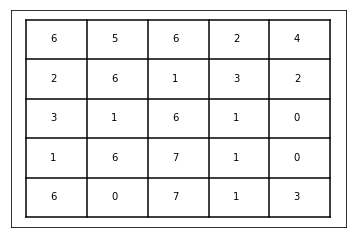

In [78]:
simul1.perturb_transition()
simul1.draw_world()

In [79]:
states1, obs1 = simul1.multi_generate(N = 200, num = 10, path_type = "markov_generate_conti")

In [82]:
hmm1 = HMM(simul1, states1, obs1)

NameError: name 'T_normalize' is not defined

In [53]:
print(hmm1.trans[0,:])
print(simul1.T[0,:])

[0.6 0.2 0.  0.  0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0. ]
[0.55  0.225 0.    0.    0.    0.225 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.   ]


In [54]:
hmm1.train()

97


In [55]:
viter1 = Viterbi(hmm1)
xstar1 = viter1.mostLikelySequence(obs1)
acc1 = measureAccuracy(xstar1, states1)

In [56]:
acc1

0.46449999999999997

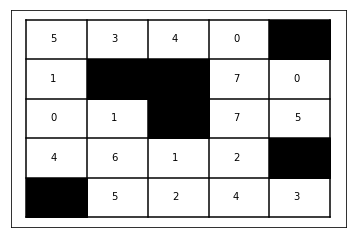

In [68]:
simul2 = HMM_Simulator(seed = 1, sigma = 0.5, map_size = 5, obs_size = 8, obstacles=[4, 6, 7, 12, 19, 20])
simul2.perturb_transition()
simul2.draw_world()

In [69]:
states2, obs2 = simul2.multi_generate(N = 200, num = 10, path_type = "markov_generate_conti")

In [70]:
hmm2 = HMM(simul2, states2, obs2)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  from ipykernel import kernelapp as app


In [60]:
hmm2.train()

26


In [74]:
hmm2.trans[3,:]

array([0. , 0. , 0.2, 0.4, 0.2, 0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])

In [62]:
viter2 = Viterbi(hmm2)
xstar2 = viter1.mostLikelySequence(obs2)
acc2 = measureAccuracy(xstar2, states2)
print(acc2)

0.9875


In [65]:
print(simul2.T[5,:])
print(hmm2.trans[5,:])

[0.20333333 0.         0.         0.         0.         0.39
 0.20333333 0.         0.         0.         0.20333333 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
[0.1157701  0.         0.         0.         0.         0.42635627
 0.15150427 0.         0.         0.         0.232253   0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
